In [1]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from statannotations.Annotator import Annotator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import io

Data preparation

In [2]:
feat = pd.read_csv('results-coculture_quant.csv')
annotations = pd.read_csv("results-coculture-molecularanalysis.tsv", sep = "\t")
annotations = annotations[["SpectrumID","Compound_Name","#Scan#","MQScore"]]

In [3]:
feat.set_index("row ID", inplace=True)

In [4]:
feat.drop('Unnamed: 58', axis=1, inplace=True)

In [5]:
feat_edit1 = feat.drop('row m/z', axis=1).drop('row retention time', axis=1).drop('Pad_hidro.mzML Peak area',axis=1)

In [6]:
sorted_columns = sorted(feat_edit1.columns)
feat_edit1 = feat_edit1[sorted_columns]

In [7]:
feat_edit = feat_edit1.T

In [8]:
feat_edit['Timepoints'] = ['0','0','0','1','1','1','2','2','2','3','3','3','4','4','4','5','5','5','6','6','6','7','7','7','8','8','8','9','9','9','10','10','10','11','11','11','12','12','12','13','13','13','14','14','14','15','15','15','16','16','16','17','17','17']

In [9]:
column = feat_edit.pop('Timepoints') #cutting the timepoint column
feat_edit.insert(0, column.name, column) #reinserting the column at position 0

Clustering

In [10]:
timepoints = feat_edit['Timepoints']
compounds_data = feat_edit.drop('Timepoints', axis=1)

In [11]:
# Scaling the compounds
scaler = StandardScaler()
compounds_data_scaled = scaler.fit_transform(compounds_data)

In [12]:
# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(compounds_data_scaled)

In [13]:
# Concatenating PCA components with Timepoints
df_final = pd.DataFrame(data=principal_components,
                        columns=['Principal Component 1', 'Principal Component 2'])
df_final['Timepoints'] = timepoints.reset_index(drop=True)

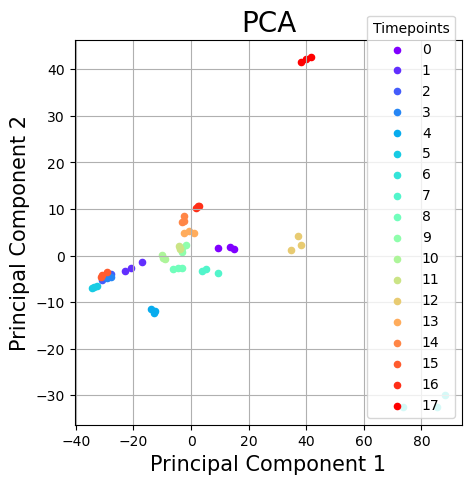

In [14]:
# Plotting
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('PCA', fontsize=20)

# Assuming you have a list of unique timepoints
unique_timepoints = feat_edit['Timepoints'].unique()

# Assigning colors for each timepoint
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_timepoints)))

for timepoint, color in zip(unique_timepoints, colors):
    indicesToKeep = df_final['Timepoints'] == timepoint
    ax.scatter(df_final.loc[indicesToKeep, 'Principal Component 1'],
               df_final.loc[indicesToKeep, 'Principal Component 2'],
               c=color.reshape(1, -1),  # Reshape color array to match dimensions
               s=20, label=str(timepoint))

ax.legend(title='Timepoints', loc='lower right')
ax.grid()

plt.show()

In [15]:
feat_edit_int = feat_edit
feat_edit_int['Timepoints'] = feat_edit['Timepoints'].astype(int)
minha_paleta = dict(zip(feat_edit_int.Timepoints.unique(), colors))
cores_linhas = feat_edit_int.Timepoints.map(minha_paleta)

/home/joao/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


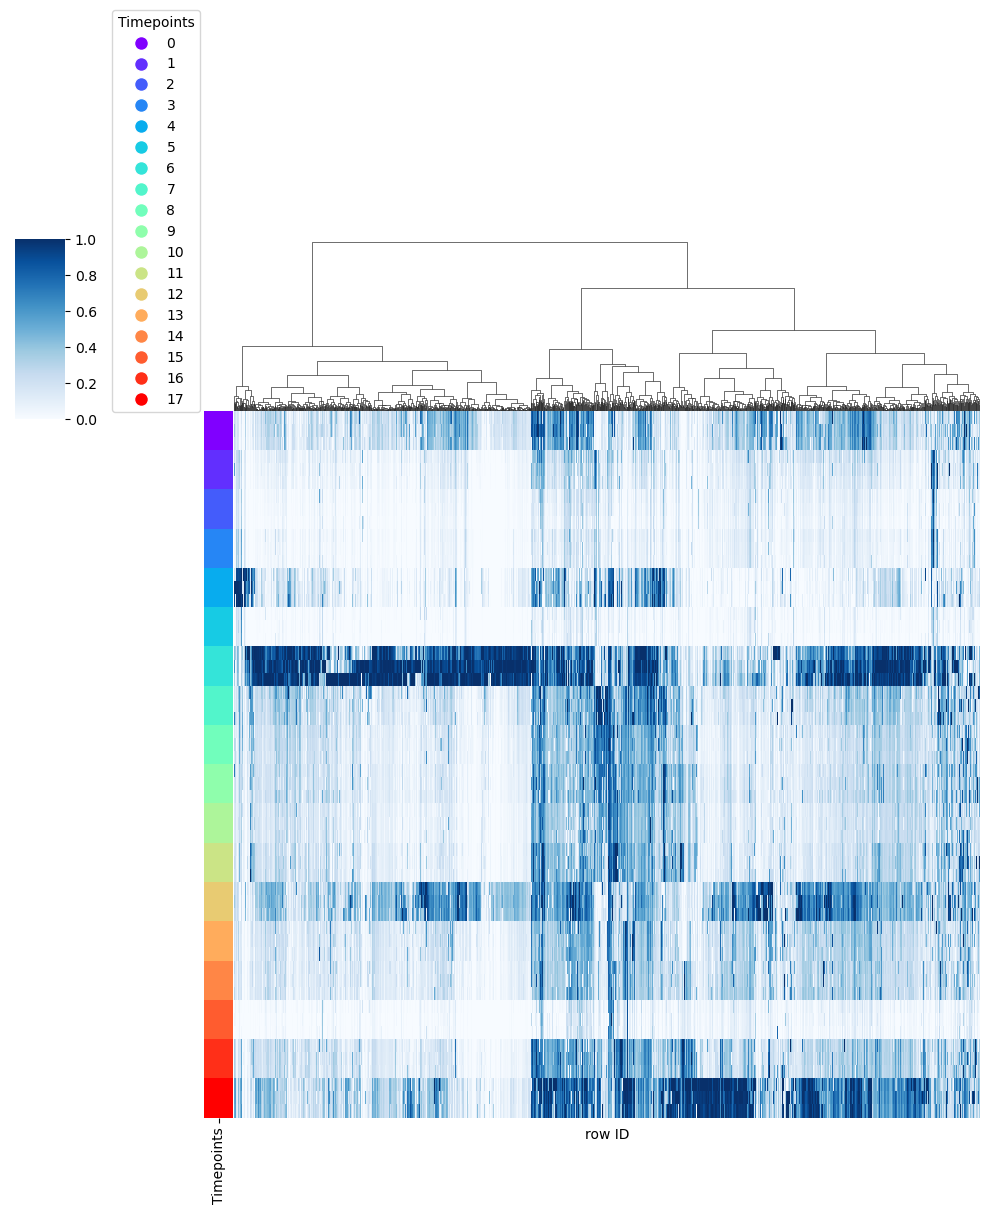

In [16]:
# Creating heatmap and dendrogram (euclidean)
sns.clustermap(feat_edit_int, metric="euclidean", method="ward", 
               cmap="Blues", standard_scale=1, row_colors=cores_linhas, xticklabels=False, yticklabels=False, row_cluster=False)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=str(k),
                               markerfacecolor=v, markersize=10) for k, v in minha_paleta.items()]
plt.legend(handles=legend_elements, title='Timepoints', loc='lower left', bbox_to_anchor=(1.8, 0))

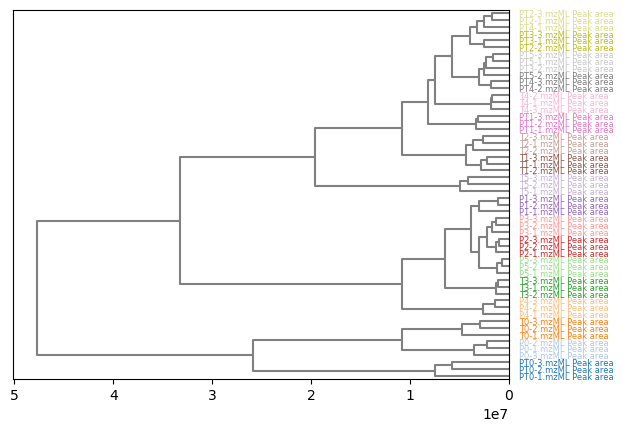

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculating the distance between the objects
Z = linkage(feat_edit_int, 'ward')
 
# Building a dendrogram
dendrogram(Z, labels=feat_edit_int.index, leaf_rotation=0, 
           orientation="left", color_threshold=240, above_threshold_color='grey')
 
# Creating a color palette
minha_paleta2 = plt.get_cmap("tab20")
n_colors = 18
paleta_customizada = plt.cm.get_cmap('viridis', n_colors)
 
# Making Timepoints a Categorical variable to allow associating each color to a timepoint
feat_edit_int['Timepoints'] = pd.Categorical(feat_edit_int['Timepoints'])
minhas_cores = feat_edit_int['Timepoints'].cat.codes
 
# Applying the colors to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num += 1
    val = minhas_cores[num]
    lbl.set_color(minha_paleta2(val))

Associating metabolites to their ID

In [18]:
mean_group = feat_edit.groupby("Timepoints").mean() #calculating the mean for each timepoint

In [19]:
features = pd.read_csv('results-coculture_quant.csv').drop('Unnamed: 58', axis=1).drop('Pad_hidro.mzML Peak area',axis=1)
feat_annot = features
sorted_columns1 = sorted(feat_annot.columns)
feat_annot = feat_annot[sorted_columns1]

In [20]:
feat_annot.head()

,P0-1.mzML Peak area,P0-2.mzML Peak area,P0-3.mzML Peak area,P1-1.mzML Peak area,P1-2.mzML Peak area,P1-3.mzML Peak area,P2-1.mzML Peak area,P2-2.mzML Peak area,P2-3.mzML Peak area,P3-1.mzML Peak area,...,T3-3.mzML Peak area,T4-1.mzML Peak area,T4-2.mzML Peak area,T4-3.mzML Peak area,T5-1.mzML Peak area,T5-2.mzML Peak area,T5-3.mzML Peak area,row ID,row m/z,row retention time
0,1.807144e+06,1.652730e+06,1.629721e+06,704920.509944,883308.695802,860413.13257,628123.119419,585580.258469,539477.521238,624265.882817,...,594796.865487,1.174871e+06,1.280432e+06,1.329666e+06,1.558153e+06,1.654111e+06,1.408170e+06,1,75.035457,7.651273
1,4.549282e+05,1.032530e+05,4.229392e+05,112219.950000,177159.498901,92103.45000,96150.759544,98125.498530,87271.367897,58634.971389,...,243231.418492,2.377418e+05,2.263101e+05,2.137735e+05,2.324313e+05,2.439191e+05,2.468213e+05,2,73.050003,7.655093
2,8.140832e+04,7.537650e+04,7.393740e+04,71147.400800,65973.134130,56018.70000,47693.400000,45528.300000,38377.800000,44937.450000,...,94451.700000,8.727639e+04,8.580910e+04,8.484729e+04,8.582650e+04,8.329122e+04,8.084652e+04,3,131.100686,7.655463
3,5.722425e+04,5.902080e+04,5.258265e+04,51325.050000,40986.300000,38973.60000,41007.150000,41047.500000,35503.500000,27750.750000,...,48966.000000,4.998180e+04,5.417438e+04,5.073405e+04,6.301494e+04,6.649929e+04,6.334209e+04,4,147.055734,7.730185
4,6.176539e+04,6.389865e+04,6.567499e+04,51431.008570,41939.400000,38526.15000,35371.200000,32771.700000,29616.750000,28704.150000,...,56808.482228,5.769453e+04,5.420640e+04,5.996691e+04,6.621301e+04,6.129720e+04,5.442285e+04,5,147.055159,8.009537


Phanerochaete chrysosporium

In [21]:
#Adding pearsonr stats to a list
from scipy import stats
mean_group_PC = mean_group.iloc[:6]
pears_list_PC =[]
p_values_PC = []
for i in mean_group_PC.columns:
    x = [0, 1, 2, 3, 4, 5]
    y = mean_group_PC[i]
    corr_coef, p_value = stats.pearsonr(x, y)
    pears_list_PC.append(corr_coef)
    p_values_PC.append(p_value)


/home/joao/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [22]:
feat_annot_PC = feat_annot.iloc[ : , :18]

In [23]:
feat_annot_PC['correlation'] = pears_list_PC
feat_annot_PC['pvalue'] = p_values_PC
feat_annot_PC = feat_annot_PC.assign(
    **features[['row ID', 'row m/z', 'row retention time']].to_dict('series')
)

In [24]:
feat_annotations_PC = pd.merge(feat_annot_PC[["row ID", "row m/z", "row retention time", "correlation", "pvalue"]],annotations,left_on='row ID', right_on='#Scan#', how="left")

In [25]:
feat_annotations_PC = feat_annotations_PC.dropna(subset=['MQScore'])

# Use groupby and idxmax to keep rows with the highest MQScore for each row ID
feat_annotations_PC_1 = feat_annotations_PC.loc[feat_annotations_PC.groupby('row ID')['MQScore'].idxmax()]

# Reset the index if necessary
feat_annotations_PC_1 = feat_annotations_PC_1.reset_index(drop=True)


In [26]:
feat_annotations_PC_1

,row ID,row m/z,row retention time,correlation,pvalue,SpectrumID,Compound_Name,#Scan#,MQScore
0,1,75.035457,7.651273,-0.359577,0.483881,CCMSLIB00005450757,TRIMETHYL ORTHOFORMATE,1.0,0.924995
1,2,73.050003,7.655093,-0.438211,0.384758,CCMSLIB00000990459,"2,4-Dimethyl-3-pentanol, TMS derivative",2.0,0.829446
2,3,131.100686,7.655463,-0.120821,0.819651,CCMSLIB00005684989,dl-7-Azatryptophan,3.0,0.777544
3,9,145.100489,8.099815,-0.120261,0.820478,CCMSLIB00001049760,"2,3,6-Trifluorobenzyl alcohol, 1-methylpropyl ...",9.0,0.687658
4,11,77.021905,8.119630,-0.314374,0.543973,CCMSLIB00005467165,TITLE=Fiehn VocBinbase Bin #1065,11.0,0.802994
...,...,...,...,...,...,...,...,...,...
705,1473,209.031825,41.229455,-0.703568,0.118784,CCMSLIB00001022090,"Anthracen-9-one, 10-heptyl-10-hydroxy-",1473.0,0.723475
706,1478,371.265900,41.769352,-0.760287,0.079306,CCMSLIB00000999073,"1,3-Dipalmitin, TMS derivative",1478.0,0.714249
707,1480,73.051821,41.796636,-0.871951,0.023545,CCMSLIB00000945579,"1,3-Dioxolane, 2-pentadecyl-",1480.0,0.747226
708,1493,73.051026,44.667273,-0.737303,0.094450,CCMSLIB00000945879,"Silane, (diphenylmethyl)trimethyl-",1493.0,0.731179


In [27]:
significant_PC = feat_annotations_PC_1[feat_annotations_PC_1['correlation'].abs() < 0.80]

Trichoderma reesei

In [28]:
#Adding pearsonr stats to a list
from scipy import stats
mean_group_TR = mean_group.iloc[12:18]
pears_list_TR =[]
p_values_TR = []
for i in mean_group_TR.columns:
    x = [0, 1, 2, 3, 4, 5]
    y = mean_group_TR[i]
    corr_coef, p_value = stats.pearsonr(x, y)
    pears_list_TR.append(corr_coef)
    p_values_TR.append(p_value)

/home/joao/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
feat_annot_TR = feat_annot.iloc[ : , 36:54]

In [30]:
feat_annot_TR['correlation'] = pears_list_TR
feat_annot_TR['pvalue'] = p_values_TR
feat_annot_TR = feat_annot_TR.assign(
    **features[['row ID', 'row m/z', 'row retention time']].to_dict('series')
)

In [31]:
feat_annotations_TR = pd.merge(feat_annot_TR[["row ID", "row m/z", "row retention time", "correlation", "pvalue"]],annotations,left_on='row ID', right_on='#Scan#', how="left")

In [32]:
feat_annotations_TR = feat_annotations_TR.dropna(subset=['MQScore'])

# Use groupby and idxmax to keep rows with the highest MQScore for each row ID
feat_annotations_TR_1 = feat_annotations_TR.loc[feat_annotations_TR.groupby('row ID')['MQScore'].idxmax()]

# Reset the index if necessary
feat_annotations_TR_1 = feat_annotations_TR_1.reset_index(drop=True)

In [33]:
significant_TR = feat_annotations_TR_1[feat_annotations_TR_1['correlation'].abs() < 0.80]
significant_TR.shape

(675, 9)

P. chrysosporium and T. reesei

In [34]:
#Adding pearsonr stats to a list
from scipy import stats
mean_group_PT = mean_group.iloc[6:12]
pears_list_PT =[]
p_values_PT = []
for i in mean_group_PT.columns:
    x = [0, 1, 2, 3, 4, 5]
    y = mean_group_PT[i]
    corr_coef, p_value = stats.pearsonr(x, y)
    pears_list_PT.append(corr_coef)
    p_values_PT.append(p_value)

In [35]:
feat_annot_PT = feat_annot.iloc[ : , 18:36]

In [36]:
feat_annot_PT['correlation'] = pears_list_PT
feat_annot_PT['pvalue'] = p_values_PT
feat_annot_PT = feat_annot_TR.assign(
    **features[['row ID', 'row m/z', 'row retention time']].to_dict('series')
)

In [37]:
feat_annotations_PT = pd.merge(feat_annot_PT[["row ID", "row m/z", "row retention time", "correlation", "pvalue"]],annotations,left_on='row ID', right_on='#Scan#', how="left")

In [38]:
feat_annotations_PT = feat_annotations_PT.dropna(subset=['MQScore'])

# Use groupby and idxmax to keep rows with the highest MQScore for each row ID
feat_annotations_PT_1 = feat_annotations_PT.loc[feat_annotations_PT.groupby('row ID')['MQScore'].idxmax()]

# Reset the index if necessary
feat_annotations_PT_1 = feat_annotations_PT_1.reset_index(drop=True)

In [39]:
significant_PT = feat_annotations_PT_1[feat_annotations_PT_1['correlation'].abs() < 0.80]
significant_TR

,row ID,row m/z,row retention time,correlation,pvalue,SpectrumID,Compound_Name,#Scan#,MQScore
0,1,75.035457,7.651273,-0.305756,0.555658,CCMSLIB00005450757,TRIMETHYL ORTHOFORMATE,1.0,0.924995
1,2,73.050003,7.655093,-0.637745,0.173074,CCMSLIB00000990459,"2,4-Dimethyl-3-pentanol, TMS derivative",2.0,0.829446
2,3,131.100686,7.655463,-0.354794,0.490139,CCMSLIB00005684989,dl-7-Azatryptophan,3.0,0.777544
4,11,77.021905,8.119630,0.606255,0.202031,CCMSLIB00005467165,TITLE=Fiehn VocBinbase Bin #1065,11.0,0.802994
6,13,75.044366,8.164909,-0.305579,0.555899,CCMSLIB00005450600,TERT-BUTYLDIMETHYLSILANOL,13.0,0.895807
...,...,...,...,...,...,...,...,...,...
705,1473,209.031825,41.229455,-0.575991,0.231560,CCMSLIB00001022090,"Anthracen-9-one, 10-heptyl-10-hydroxy-",1473.0,0.723475
706,1478,371.265900,41.769352,-0.103006,0.846037,CCMSLIB00000999073,"1,3-Dipalmitin, TMS derivative",1478.0,0.714249
707,1480,73.051821,41.796636,0.053540,0.919766,CCMSLIB00000945579,"1,3-Dioxolane, 2-pentadecyl-",1480.0,0.747226
708,1493,73.051026,44.667273,-0.272065,0.601971,CCMSLIB00000945879,"Silane, (diphenylmethyl)trimethyl-",1493.0,0.731179


Timepoint Zero

In [40]:
feat_zero = mean_group.T

In [41]:
feat_zero.head()

Timepoints,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
row ID,,,,,,,,,,,,,,,,,,
1,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,1.295376e+06,1.420525e+06,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06
2,3.270401e+05,127160.966300,93849.208657,55339.527392,2.245349e+05,111051.635904,6.095257e+05,1.454934e+05,2.758005e+05,2.846975e+05,2.795158e+05,2.550228e+05,5.325683e+05,2.298025e+05,2.308717e+05,212195.523538,2.259418e+05,2.410572e+05
3,7.690741e+04,64379.744976,43866.500000,41009.750000,1.037220e+05,42590.245436,6.738960e+04,1.061181e+05,1.108249e+05,1.080285e+05,1.078203e+05,1.124214e+05,8.548265e+04,9.615984e+04,9.869998e+04,95735.155830,8.597759e+04,8.332141e+04
4,5.627590e+04,43761.650000,39186.050000,27038.550000,4.700135e+04,24642.850000,1.713803e+05,5.763170e+04,5.529630e+04,5.430060e+04,6.028705e+04,5.916865e+04,6.689870e+04,5.503730e+04,5.653050e+04,48955.100000,5.163008e+04,6.428544e+04
5,6.377968e+04,43965.519523,32586.550000,26602.250000,5.837461e+04,27722.950000,8.212725e+04,6.822396e+04,6.890279e+04,6.664499e+04,6.650151e+04,6.888049e+04,7.148155e+04,6.412558e+04,6.394100e+04,56956.744777,5.728928e+04,6.064435e+04


In [42]:
feat_zero_annot = pd.merge(feat_zero,annotations,left_on='row ID', right_on='#Scan#', how="left")

In [43]:
feat_zero_annot.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore
0,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00005450757,TRIMETHYL ORTHOFORMATE,1.0,0.924995
1,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00005450600,TERT-BUTYLDIMETHYLSILANOL,1.0,0.922048
2,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00000940414,tert-Butyldimethylsilanol,1.0,0.922028
3,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00000940106,"Silanol, trimethyl-",1.0,0.918701
4,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00005685304,"""Ethanol, 2-(trimethylsilyl)-""",1.0,0.906283


In [44]:
feat_zero_annot = feat_zero_annot.dropna(subset=['MQScore'])

# Use groupby and idxmax to keep rows with the highest MQScore for each row ID
feat_zero_annotation = feat_zero_annot.loc[feat_zero_annot.groupby('#Scan#')['MQScore'].idxmax()]

# Reset the index if necessary
feat_zero_annotation = feat_zero_annotation.reset_index(drop=True)

In [45]:
feat_zero_annotation.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore
0,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,1.808492e+06,1.563481e+06,1.418769e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00005450757,TRIMETHYL ORTHOFORMATE,1.0,0.924995
1,3.270401e+05,127160.966300,93849.208657,55339.527392,2.245349e+05,111051.635904,6.095257e+05,1.454934e+05,2.758005e+05,2.846975e+05,...,5.325683e+05,2.298025e+05,2.308717e+05,212195.523538,2.259418e+05,2.410572e+05,CCMSLIB00000990459,"2,4-Dimethyl-3-pentanol, TMS derivative",2.0,0.829446
2,7.690741e+04,64379.744976,43866.500000,41009.750000,1.037220e+05,42590.245436,6.738960e+04,1.061181e+05,1.108249e+05,1.080285e+05,...,8.548265e+04,9.615984e+04,9.869998e+04,95735.155830,8.597759e+04,8.332141e+04,CCMSLIB00005684989,dl-7-Azatryptophan,3.0,0.777544
3,1.174420e+04,9544.500000,7830.400000,6787.400000,1.607628e+04,6375.700000,1.672850e+04,1.685489e+04,1.743149e+04,1.624569e+04,...,1.571050e+04,1.496440e+04,1.465239e+04,13646.090398,1.261069e+04,1.177660e+04,CCMSLIB00001049760,"2,3,6-Trifluorobenzyl alcohol, 1-methylpropyl ...",9.0,0.687658
4,3.732443e+04,15605.550000,17776.987601,10766.650000,3.738392e+04,10999.150000,3.863750e+04,3.452869e+04,3.077301e+04,4.166335e+04,...,2.528920e+04,2.316645e+04,3.144271e+04,21009.724889,2.720080e+04,4.284479e+04,CCMSLIB00005467165,TITLE=Fiehn VocBinbase Bin #1065,11.0,0.802994


In [46]:
feat_zero_PC = feat_zero_annotation[feat_zero_annotation.iloc[:, 0] == 0.0]
feat_zero_TR = feat_zero_annotation[feat_zero_annotation.iloc[:, 12] == 0.0]
feat_zero_PT = feat_zero_annotation[feat_zero_annotation.iloc[:, 6] == 0.0]


In [47]:
feat_zero_TR

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore
164,0.0,952501.450009,447993.300002,654979.200006,1.289112e+06,333230.000002,2079.000000,1.055943e+06,1.052250e+06,1.071452e+06,...,0.0,412596.320956,357088.403127,211217.956132,1.237908e+06,964630.354997,CCMSLIB00000884954,"2,4-Dichlorobenzoic acid, TMS derivative",215.0,0.930137
221,0.0,0.000000,0.000000,0.000000,1.297665e+04,0.000000,8084.350000,1.263719e+04,1.115454e+04,9.992400e+03,...,0.0,8171.000000,7663.547966,0.000000,1.202763e+04,30870.502580,CCMSLIB00005681079,6-Benzothiazolamine,300.0,0.651872
310,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,50276.781297,0.000000e+00,1.485000e+02,5.213400e+03,...,0.0,0.000000,4828.850000,798.000000,3.634641e+04,53472.455691,CCMSLIB00005459882,N-acetyl-leucine,437.0,0.660823


In [48]:
feat_zero_PT

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore
561,88208.193616,14318.60,8910.650000,8191.65,5846.0,4978.30,0.0,1689.35,43657.303516,28748.851592,...,55246.458681,11498.300000,7470.250000,1425.9,38572.764771,19190.700000,CCMSLIB00005674134,""".alpha.-Bromo-2,4-difluorotoluene""",983.0,0.653019
659,44853.968059,14868.85,17520.851813,9330.15,20974.5,10654.45,0.0,12707.60,0.000000,12365.450000,...,58756.950000,123272.724503,175523.443587,6149.3,82350.050000,20654.843729,CCMSLIB00000866497,"2-Propylphenol, TMS derivative",1293.0,0.663592


In [49]:
feat_zero_PC_total = feat_zero_annotation[(feat_zero_annotation.iloc[:, :6] == 0.0).all(axis=1)]
feat_zero_TR_total = feat_zero_annotation[(feat_zero_annotation.iloc[:, 12:18] == 0.0).all(axis=1)]
feat_zero_PT_total = feat_zero_annotation[(feat_zero_annotation.iloc[:, 6:12] == 0.0).all(axis=1)]

In [50]:
feat_zero_PC_total

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore
238,0.0,0.0,0.0,0.0,0.0,0.0,7078.850000,4664.4,8674.25,24009.578921,...,2646.2,0.0,5754.35,5954.75,54427.237575,54138.239312,CCMSLIB00001019414,"1,3-Dithiaindane, 2-(3-methylbutoxy)-4-(triflu...",332.0,0.652973
310,0.0,0.0,0.0,0.0,0.0,0.0,50276.781297,0.0,148.50,5213.400000,...,0.0,0.0,4828.85,798.00,36346.408400,53472.455691,CCMSLIB00005459882,N-acetyl-leucine,437.0,0.660823
338,0.0,0.0,0.0,0.0,0.0,0.0,8431.500000,8271.1,13014.00,19557.497854,...,2194.2,7911.8,10281.70,2359.20,21371.080589,59191.227949,CCMSLIB00001000061,"Phosphine, 1,3-propanediylbis[dicyclohexyl-",486.0,0.696844


In [51]:
feat_zero_TR_total

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore


In [52]:
feat_zero_PT_total

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore


Plots

In [53]:
plot_PC = pd.merge(feat_annotations_PC_1[["row ID", "correlation","pvalue"]],feat_zero_annot,left_on='row ID', right_on='#Scan#', how="left")
plot_TR = pd.merge(feat_annotations_TR_1[["row ID", "correlation","pvalue"]],feat_zero_annot,left_on='row ID', right_on='#Scan#', how="left")
plot_PT = pd.merge(feat_annotations_PT_1[["row ID", "correlation","pvalue"]],feat_zero_annot,left_on='row ID', right_on='#Scan#', how="left")

In [54]:
plot_PC = plot_PC.dropna(subset=['MQScore'])
plot_TR = plot_TR.dropna(subset=['MQScore'])
plot_PT = plot_PT.dropna(subset=['MQScore'])

# Use groupby and idxmax to keep rows with the highest MQScore for each row ID
plot_PC_n = plot_PC.loc[plot_PC.groupby('#Scan#')['MQScore'].idxmax()]
plot_TR_n = plot_TR.loc[plot_TR.groupby('#Scan#')['MQScore'].idxmax()]
plot_PT_n = plot_PT.loc[plot_PT.groupby('#Scan#')['MQScore'].idxmax()]

# Reset the index if necessary
plot_PC_n = plot_PC_n.reset_index(drop=True)
plot_TR_n = plot_TR_n.reset_index(drop=True)
plot_PT_n = plot_PT_n.reset_index(drop=True)

In [55]:
plot_PC_n.head()

,row ID,correlation,pvalue,0,1,2,3,4,5,6,...,12,13,14,15,16,17,SpectrumID,Compound_Name,#Scan#,MQScore
0,1,-0.359577,0.483881,1.696532e+06,816214.112772,584393.633042,592796.340726,1.596712e+06,500700.257109,4.248843e+06,...,1.916679e+06,1.266847e+06,1.166234e+06,632739.514816,1.261656e+06,1.540144e+06,CCMSLIB00005450757,TRIMETHYL ORTHOFORMATE,1.0,0.924995
1,2,-0.438211,0.384758,3.270401e+05,127160.966300,93849.208657,55339.527392,2.245349e+05,111051.635904,6.095257e+05,...,5.325683e+05,2.298025e+05,2.308717e+05,212195.523538,2.259418e+05,2.410572e+05,CCMSLIB00000990459,"2,4-Dimethyl-3-pentanol, TMS derivative",2.0,0.829446
2,3,-0.120821,0.819651,7.690741e+04,64379.744976,43866.500000,41009.750000,1.037220e+05,42590.245436,6.738960e+04,...,8.548265e+04,9.615984e+04,9.869998e+04,95735.155830,8.597759e+04,8.332141e+04,CCMSLIB00005684989,dl-7-Azatryptophan,3.0,0.777544
3,9,-0.120261,0.820478,1.174420e+04,9544.500000,7830.400000,6787.400000,1.607628e+04,6375.700000,1.672850e+04,...,1.571050e+04,1.496440e+04,1.465239e+04,13646.090398,1.261069e+04,1.177660e+04,CCMSLIB00001049760,"2,3,6-Trifluorobenzyl alcohol, 1-methylpropyl ...",9.0,0.687658
4,11,-0.314374,0.543973,3.732443e+04,15605.550000,17776.987601,10766.650000,3.738392e+04,10999.150000,3.863750e+04,...,2.528920e+04,2.316645e+04,3.144271e+04,21009.724889,2.720080e+04,4.284479e+04,CCMSLIB00005467165,TITLE=Fiehn VocBinbase Bin #1065,11.0,0.802994


P. chrysosporium

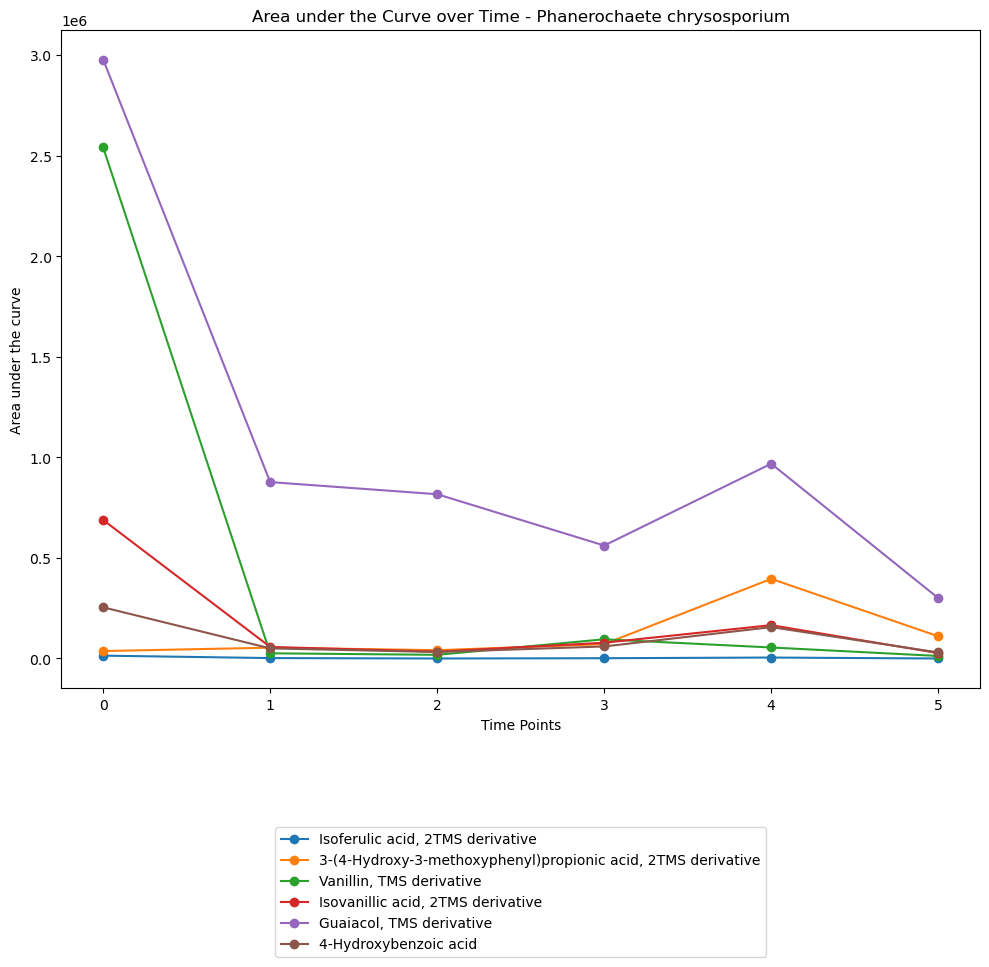

In [56]:
# Define the row IDs of the specific rows you want to plot
row_id1 = 418 # ferulic acid
row_id2 = 335 # 3-(4-Hydroxy-3-methoxyphenyl)propionic acid
row_id3 = 207 # vanillin
row_id4 = 284 # vanillic acid
row_id5 = 103 # guaiacol
row_id6 = 281 # 4-hydroxybenzoic acid

# Find the indices of the specified row IDs
row1_index = plot_PC_n.index[plot_PC_n['row ID'] == row_id1].tolist()[0]
row2_index = plot_PC_n.index[plot_PC_n['row ID'] == row_id2].tolist()[0]
row3_index = plot_PC_n.index[plot_PC_n['row ID'] == row_id3].tolist()[0]
row4_index = plot_PC_n.index[plot_PC_n['row ID'] == row_id4].tolist()[0]
row5_index = plot_PC_n.index[plot_PC_n['row ID'] == row_id5].tolist()[0]
row6_index = plot_PC_n.index[plot_PC_n['row ID'] == row_id6].tolist()[0]


# Extract compound names for the specific rows
compounds = plot_PC_n.loc[[row1_index,row2_index,row3_index,row4_index, row5_index,row6_index], 'Compound_Name']

# Extract concentration data (time points) from the DataFrame
time_points = plot_PC_n.columns[3:9]  # columns from 'Time 1' to 'Time 6'

# Plotting
plt.figure(figsize=(10, 10))

# Plot concentrations over time for the specific rows
for row_id, row_index in zip([row_id1, row_id2,row_id3,row_id4, row_id5,row_id6], [row1_index, row2_index,row3_index,row4_index, row5_index,row6_index],):
    compound = plot_PC_n.loc[row_index, 'Compound_Name']
    concentrations = plot_PC_n.iloc[row_index, 3:9]  # concentrations for the current compound
    plt.plot(time_points, concentrations, marker='o', label=f'{compound}')

# Customize the plot
plt.title('Area under the Curve over Time - Phanerochaete chrysosporium')
plt.xlabel('Time Points')
plt.ylabel('Area under the curve')
plt.xticks()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=1, prop={'size': 10})

# Show plot
plt.tight_layout()
plt.show()

T. reesei

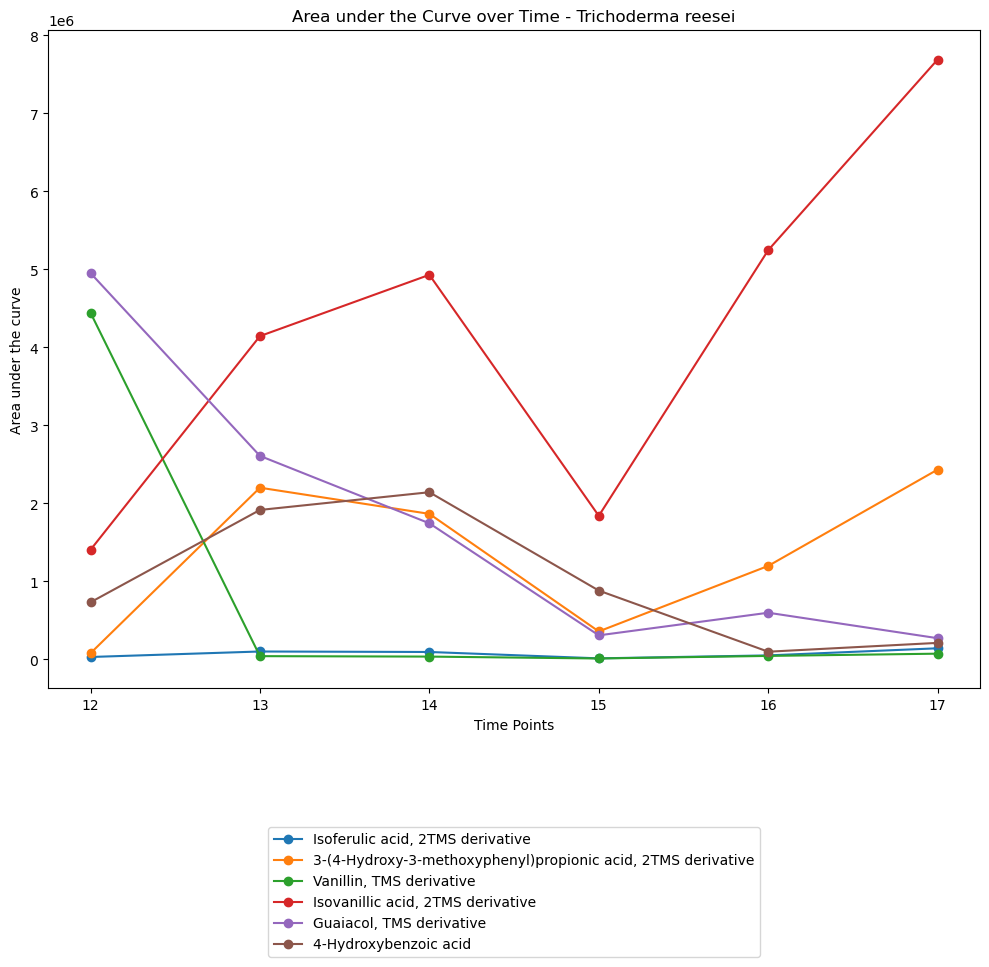

In [57]:
# Define the row IDs of the specific rows you want to plot
row_id1 = 418 # ferulic acid
row_id2 = 335 # 3-(4-Hydroxy-3-methoxyphenyl)propionic acid
row_id3 = 207 # vanillin
row_id4 = 284 # vanillic acid
row_id5 = 103 # guaiacol
row_id6 = 281 # 4-hydroxybenzoic acid

# Find the indices of the specified row IDs
row1_index = plot_TR_n.index[plot_TR_n['row ID'] == row_id1].tolist()[0]
row2_index = plot_TR_n.index[plot_TR_n['row ID'] == row_id2].tolist()[0]
row3_index = plot_TR_n.index[plot_TR_n['row ID'] == row_id3].tolist()[0]
row4_index = plot_TR_n.index[plot_TR_n['row ID'] == row_id4].tolist()[0]
row5_index = plot_TR_n.index[plot_TR_n['row ID'] == row_id5].tolist()[0]
row6_index = plot_TR_n.index[plot_TR_n['row ID'] == row_id6].tolist()[0]


# Extract compound names for the specific rows
compounds = plot_TR_n.loc[[row1_index,row2_index,row3_index,row4_index, row5_index,row6_index], 'Compound_Name']

# Extract concentration data (time points) from the DataFrame
time_points = plot_TR_n.columns[15:21]  # columns from 'Time 1' to 'Time 6'

# Plotting
plt.figure(figsize=(10, 10))

# Plot concentrations over time for the specific rows
for row_id, row_index in zip([row_id1, row_id2,row_id3,row_id4, row_id5,row_id6], [row1_index, row2_index,row3_index,row4_index, row5_index,row6_index],):
    compound = plot_TR_n.loc[row_index, 'Compound_Name']
    concentrations = plot_TR_n.iloc[row_index, 15:21]  # concentrations for the current compound
    plt.plot(time_points, concentrations, marker='o', label=f'{compound}')

# Customize the plot
plt.title('Area under the Curve over Time - Trichoderma reesei')
plt.xlabel('Time Points')
plt.ylabel('Area under the curve')
plt.xticks()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=1, prop={'size': 10})

# Show plot
plt.tight_layout()
plt.show()

P. chrysosporium and T. reesei

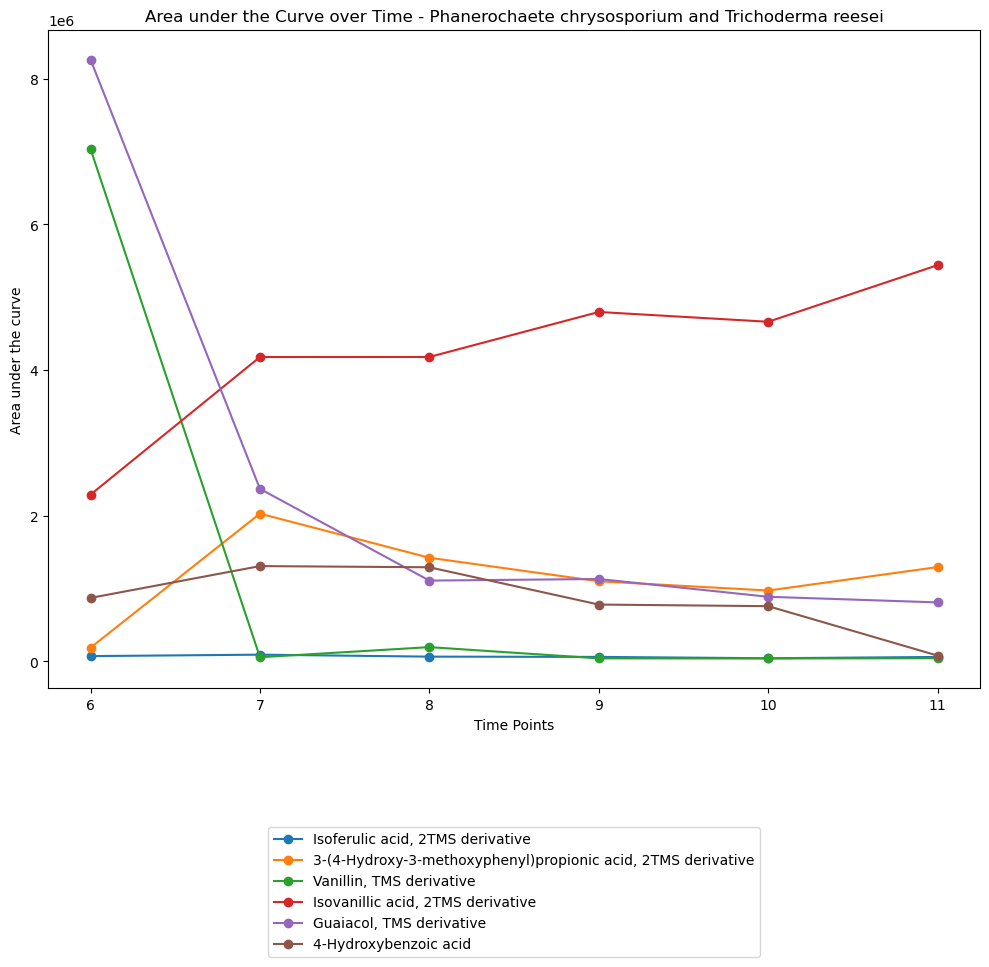

In [58]:
# Define the row IDs of the specific rows you want to plot
row_id1 = 418 # ferulic acid
row_id2 = 335 # 3-(4-Hydroxy-3-methoxyphenyl)propionic acid
row_id3 = 207 # vanillin
row_id4 = 284 # vanillic acid
row_id5 = 103 # guaiacol
row_id6 = 281 # 4-hydroxybenzoic acid

# Find the indices of the specified row IDs
row1_index = plot_PT_n.index[plot_PT_n['row ID'] == row_id1].tolist()[0]
row2_index = plot_PT_n.index[plot_PT_n['row ID'] == row_id2].tolist()[0]
row3_index = plot_PT_n.index[plot_PT_n['row ID'] == row_id3].tolist()[0]
row4_index = plot_PT_n.index[plot_PT_n['row ID'] == row_id4].tolist()[0]
row5_index = plot_PT_n.index[plot_PT_n['row ID'] == row_id5].tolist()[0]
row6_index = plot_PT_n.index[plot_PT_n['row ID'] == row_id6].tolist()[0]

# Extract compound names for the specific rows
compounds = plot_PT_n.loc[[row1_index,row2_index,row3_index,row4_index, row5_index, row6_index], 'Compound_Name']

# Extract concentration data (time points) from the DataFrame
time_points = plot_PT_n.columns[9:15]  # columns from 'Time 1' to 'Time 6'

# Plotting
plt.figure(figsize=(10, 10))

# Plot concentrations over time for the specific rows
for row_id, row_index in zip([row_id1, row_id2,row_id3,row_id4, row_id5, row_id6], [row1_index, row2_index,row3_index,row4_index, row5_index, row6_index],):
    compound = plot_PT_n.loc[row_index, 'Compound_Name']
    concentrations = plot_PT_n.iloc[row_index, 9:15]  # concentrations for the current compound
    plt.plot(time_points, concentrations, marker='o', label=f'{compound}')

# Customize the plot
plt.title('Area under the Curve over Time - Phanerochaete chrysosporium and Trichoderma reesei')
plt.xlabel('Time Points')
plt.ylabel('Area under the curve')
plt.xticks()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=1, prop={'size': 10})

# Show plot
plt.tight_layout()
plt.show()

Bar plot

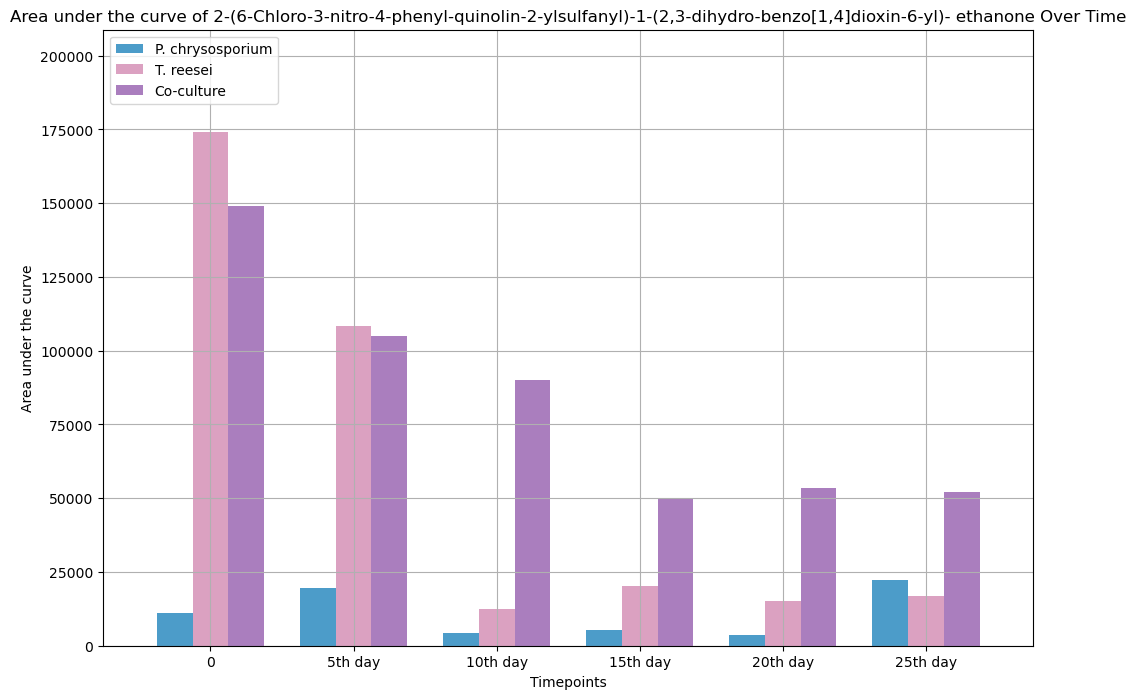

In [59]:
target_row_id = 1115

# Access the row corresponding to the 'target row id'
row_data = plot_PT_n.loc[plot_PT_n['row ID'] == target_row_id]

# Checks if the row is found and extracts the values
if not row_data.empty:
    # Get the name of the compound
    compound_name = row_data['Compound_Name'].values[0]

    # Remove column 'row ID' and 'Compound name', then get row values
    row_values = row_data.drop(columns=['row ID', 'Compound_Name']).values.flatten()

    # Convert values ​​to numeric, forcing errors to NaN
    row_values = pd.to_numeric(row_values, errors='coerce')

    # Checking if there are NaN values
    if np.any(np.isnan(row_values)):
        print("Warning: There are non-numeric values in the row data.")
        row_values = np.nan_to_num(row_values, nan=0)  # Converte NaN para 0 (ou outro valor adequado)
    
    
    # Grouping data as needed
    group1 = row_values[2:8]
    group3 = row_values[8:14]
    group2 = row_values[14:20]

    # Set the positions and width for the bars
    pos = np.arange(len(group1))  # This will create an array with positions for 6 timepoints
    width = 0.25

    colors = ['#0072B2', '#CC79A7', '#8647A3']

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create a bar for each set of data at each timepoint
    plt.bar(pos, group1, width, alpha=0.7, label='Phanerochaete chrysosporium', color=colors[0])
    plt.bar(pos + width, group2, width, alpha=0.7, label='Trichoderma reesei', color=colors[1])
    plt.bar(pos + 2*width, group3, width, alpha=0.7, label='Co-culture', color=colors[2])

    # Set the position of the x ticks
    ax.set_xticks(pos + width)

    # Set the labels for the x ticks
    ax.set_xticklabels(['0', '5th day', '10th day', '15th day', '20th day', '25th day'])

    # Setting the x-axis and y-axis limits
    plt.xlim([-0.5, len(pos)])
    plt.ylim([0, max(max(group1), max(group2), max(group3)) * 1.2])

    # Adding labels
    plt.xlabel('Timepoints')
    plt.ylabel('Area under the curve')
    
    # Setting the title to the name of the compound
    plt.title(f'Area under the curve of {compound_name} Over Time')
    # Adding the legend and showing the plot
    plt.legend(['P. chrysosporium', 'T. reesei', 'Co-culture'], loc='upper left')
    plt.grid()
    plt.show()

else:
    print("Row with the specified 'row ID' not found.")


Line plot

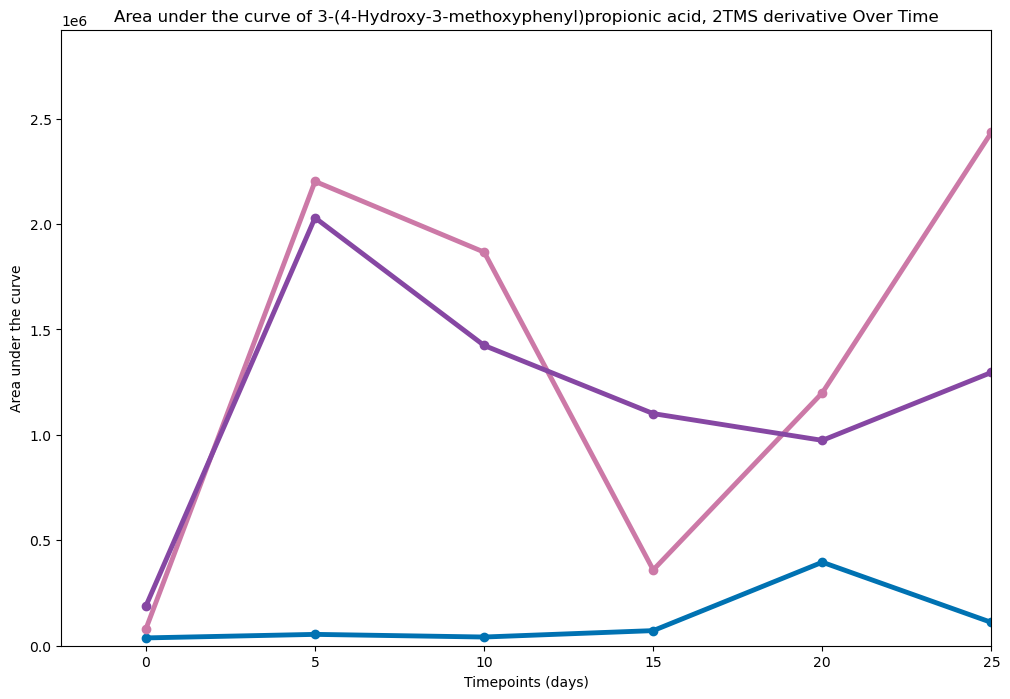

In [61]:
target_row_id = 335
# Access the row corresponding to the 'target row id'
row_data = plot_PT_n.loc[plot_PT_n['row ID'] == target_row_id]

# Checks if the row is found and extracts the values
if not row_data.empty:
    # Get the compound name
    compound_name = row_data['Compound_Name'].values[0]

    # Remove column 'row ID' and 'Compound name', then get row values
    row_values = row_data.drop(columns=['row ID', 'Compound_Name']).values.flatten()

    # Convert values ​​to numeric, forcing errors to NaN
    row_values = pd.to_numeric(row_values, errors='coerce')

    # Check if there are NaN values
    if np.any(np.isnan(row_values)):
        print("Warning: There are non-numeric values in the row data.")
        row_values = np.nan_to_num(row_values, nan=0)  # Converte NaN para 0 (ou outro valor adequado)

    # Grouping data as needed
    group1 = row_values[2:8]
    group3 = row_values[8:14]
    group2 = row_values[14:20]

    # Set the positions for the x-axis
    pos = np.arange(len(group1))  # This will create an array with positions for 6 timepoints

    # Define colors
    colors = ['#0072B2', '#CC79A7', '#8647A3']

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plotting line graphs for each group
    ax.plot(pos, group1, marker='o', linestyle='-', color=colors[0], linewidth=3.5, label='Phanerochaete chrysosporium')
    ax.plot(pos, group2, marker='o', linestyle='-', color=colors[1], linewidth=3.5, label='Trichoderma reesei')
    ax.plot(pos, group3, marker='o', linestyle='-', color=colors[2], linewidth=3.5, label='Co-culture')

    # Set the position of the x ticks
    ax.set_xticks(pos)

    # Set the labels for the x ticks
    ax.set_xticklabels(['0', '5', '10', '15', '20', '25'])
    #ax.set_yscale('log')

    # Setting the x-axis and y-axis limits
    plt.xlim([-0.5, len(pos) - 1])
    plt.ylim([0, max(max(group1), max(group2), max(group3)) * 1.2])

    # Adding labels
    plt.xlabel('Timepoints (days)')
    plt.ylabel('Area under the curve')
    
    # Setting the title to the name of the compound
    plt.title(f'Area under the curve of {compound_name} Over Time')

    # Adding the legend and showing the plot
    #plt.legend(loc='upper left')
    plt.show()

else:
    print("Row with the specified 'row ID' not found.")

